### The City of Scottsdale publishes a [dataset](http://data.scottsdaleaz.gov/dataset/planning-and-development-cases) that includes planning and development cases dating back to the 1970s.

### Which councils tend to be the most adversarial to the case applicant?  How has the composition of for/against votes changed over the years? 

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# databaseConnection = 'DRIVER={SQL Server}; SERVER=ServerName; Database=DatbaseName; UID=UserId; PWD=password;'
connection = pyodbc.connect('DRIVER={SQL Server};SERVER=WINDOWS-A6S01I2\SQLEXPRESS;DATABASE=City_of_Scottsdale;Trusted_Connection=yes;')
cursor = connection.cursor()

# query excludes observations that don't have 'meeting type', 'meeting type' is ambiguous or
# the meeting took place prior to when Scottsdale was incorporated(1951), probably human data entry error
Case_Query = '''
select *
from [dbo].[pds_CaseMeetings]
where [MeetingType] <> '' and [MeetingType] <> 'Other' and year([MeetingDate]) > '1951' 
  '''
# save the sql query to a pandas dataframe
Case_Data = pd.read_sql(Case_Query, connection)
connection.close()

Case_Data['MeetingDate'] = pd.to_datetime(Case_Data['MeetingDate']) #converte MeetingDate to datetime format
Case_Data['MeetingDate'] = Case_Data['MeetingDate'].dt.year #converte MeetingDate to year

Case_Data.head()

,meeting_id,case_id,CaseNumber,MeetingType,MeetingDate,Result,Vote
0,7571,20987,4-UP-2001,City Council Hearing,2001,APPROVED,7-0
1,7573,20988,5-UP-2001,Planning Commission Hearing,2001,CONTINUED,
2,7574,20988,5-UP-2001,City Council Hearing,2001,APPROVED,7-0
3,7575,20990,3-ZN-2001,Planning Commission Hearing,2001,CONTINUED,6-0
4,7576,20990,3-ZN-2001,City Council Hearing,2001,APPROVED,7-0


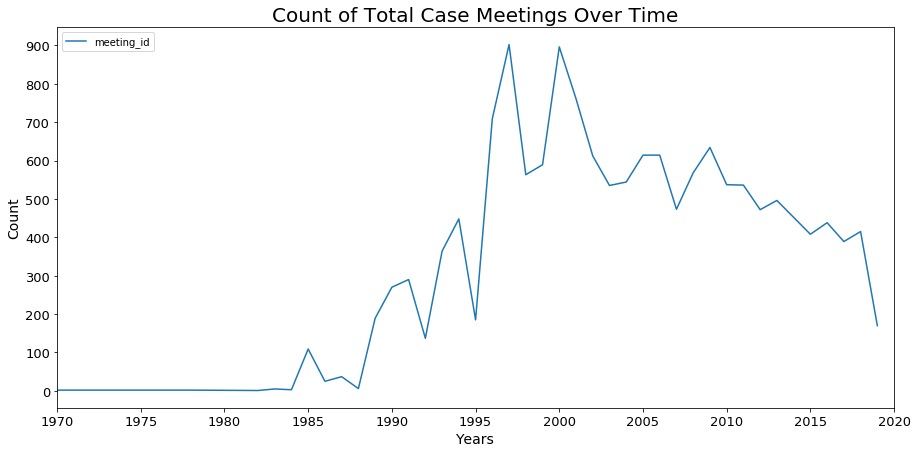

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
Case_Data.groupby(['MeetingDate']).count()['meeting_id'].plot(ax=ax)
plt.legend(loc='upper left')
plt.ylabel("Count", fontsize=14)
plt.xlabel("Years", fontsize=14)
plt.tick_params(labelsize=13)

plt.title("Count of Total Case Meetings Over Time",fontsize=20)
ax.set_xlim(1970, 2020)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))

# it seems as if the process of case hearings wasn't formalized until the mid-80s
# the drop in the late 90s is surprising to me since that was during the tech bubble
# the 2007/2008 crash doesn't show as much as I would expect

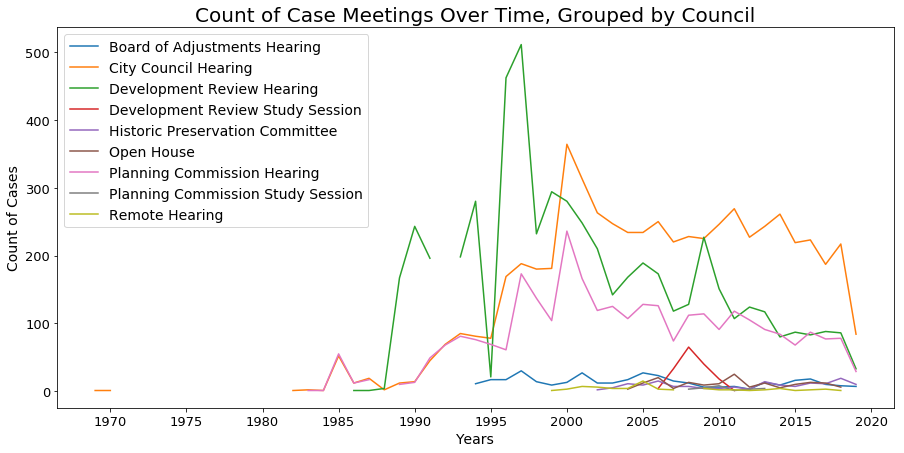

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
Case_Data.groupby(['MeetingDate','MeetingType']).count()['meeting_id'].unstack().plot(ax=ax)
plt.legend(loc='upper left', fontsize=14)
plt.ylabel("Count of Cases", fontsize=14)
plt.xlabel("Years", fontsize=14)
plt.title("Count of Case Meetings Over Time, Grouped by Council",fontsize=20)
plt.tick_params(labelsize=13)


ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))

#since around 2000, why have City Council Hearings begun to be more prevelent than Development Review Hearings?

(1995, 2020)

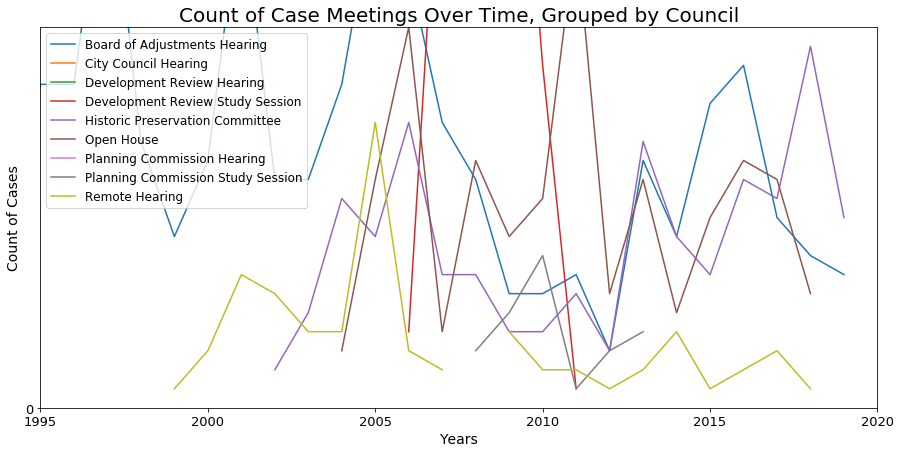

In [22]:
fig, ax = plt.subplots(figsize=(15,7))
Case_Data.groupby(['MeetingDate','MeetingType']).count()['meeting_id'].unstack().plot(ax=ax)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel("Count of Cases", fontsize=14)
plt.title("Count of Case Meetings Over Time, Grouped by Council",fontsize=20)
plt.xlabel("Years", fontsize=14)

plt.tick_params(labelsize=13)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))

ax.set_ylim(0, 20)
ax.set_xlim(1995, 2020)

# focus in on hearings with a smaller count per year
# since 2010 a much higher number of hearings for different purposes, such as 'Open House' or 'Historic Preservation Committee'

In [6]:
Case_Data.groupby(['Result'])['Result'].count().sort_values(ascending=False)
# how many unique types of Case Results are there?
# what is the count of Cases that fall into each category?
# why are there so many cases with no result value?

Result
APPROVED                          10930
CONTINUED                          1600
                                    740
WITHDRAWN                           500
DENIED                              281
RECOMMENDATION                      240
RECOMMENDATION OF APPROVAL          239
                                    236
RECOMMENDED                         190
AMENDED                             127
INFORMATIONAL ONLY                   72
PENDING                              64
ON HOLD                              49
NON-ACTION                           35
APPROVED WITH STIPS                  30
INITIATED                            24
CONSENT TO SA                        16
UPHELD                               10
CERTIFICATE OF APPROPRIATENESS        8
RECOMMENDATION OF CONTINUANCE         3
RECOMMENDATION OF DENIAL              2
CONCEPTIONALLY APPROVED               1
CERTIFICATE OF APPRO                  1
NO JURISDICTION                       1
OVERTURNED                       

In [17]:
# select only for cases either 'Approved' or 'Denied' based on hearing
Case_Data_App_Den = Case_Data.loc[(Case_Data['Result'] == 'DENIED') | (Case_Data['Result'] == 'APPROVED')]
Case_Data_App_Den.groupby(['Result'])['Result'].count()

# Count of "approved" cases vs. "denied" cases

Result
APPROVED    10930
DENIED        281
Name: Result, dtype: int64

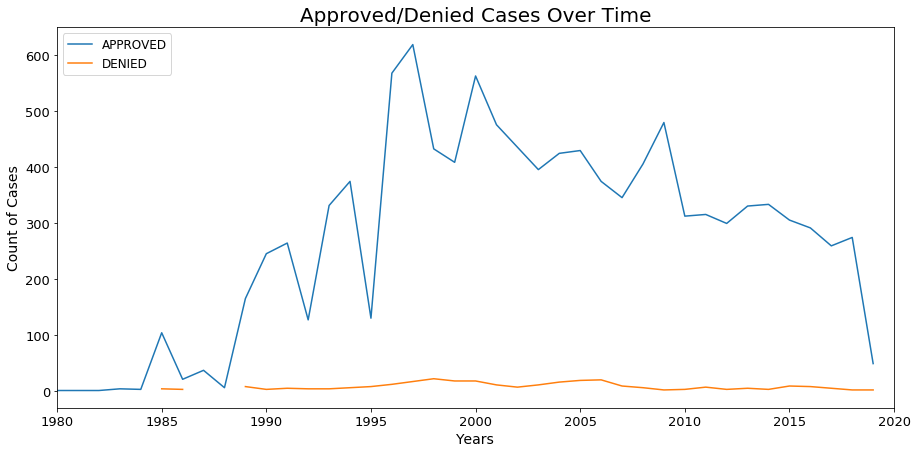

In [18]:
# Plot cases approved vs. denied over time
fig, ax = plt.subplots(figsize=(15,7))
Case_Data_App_Den.groupby(['MeetingDate','Result'])['Result'].count().unstack().plot(ax=ax)

plt.legend(loc='upper left', fontsize=12)
plt.ylabel("Count of Cases", fontsize=14)
plt.xlabel("Years", fontsize=14)
plt.title("Approved/Denied Cases Over Time",fontsize=20)
plt.tick_params(labelsize=13)
ax.set_xlim(1980, 2020)

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))

In [19]:
# form attributes to measure 'against' votes
Case_Data['Vote'] = Case_Data['Vote'].str.replace(' ','') #remove leading and trailing white spaces

Case_Data['For_Vote'] = Case_Data['Vote'].str[0].apply( \
    pd.to_numeric, args=('coerce',)) #extract 'for' votes, convert to numeric

Case_Data['Against_Vote'] = Case_Data['Vote'].str[2].apply( \
    pd.to_numeric, args=('coerce',)) #extract 'against' votes, convert to numeric

Case_Data['Opposition_Score'] = (Case_Data['Against_Vote']/Case_Data['For_Vote']).astype(float) # divide 'against' votes by 'for' votes

Sorted = Case_Data.sort_values(by=['Opposition_Score'],ascending=False)
Sorted.head(10)

,meeting_id,case_id,CaseNumber,MeetingType,MeetingDate,Result,Vote,For_Vote,Against_Vote,Opposition_Score
11544,12573,24545,102-LL-2002,City Council Hearing,2003,DENIED,0-6,0.0,6.0,inf
3155,10718,22922,2-UP-2002,Planning Commission Hearing,2002,DENIED,1-4,1.0,4.0,4.000000
10787,24882,28012,28-UP-2004,City Council Hearing,2006,DENIED,2-5,2.0,5.0,2.500000
10068,8660,6378,29-ZN-1993,Planning Commission Hearing,1993,DENIED,2-4,2.0,4.0,2.000000
685,48408,45637,60-DR-2015,Development Review Hearing,2016,DENIED,2-4,2.0,4.0,2.000000
11737,22175,29214,4-BA-2005,Board of Adjustments Hearing,2005,DENIED,3-4,3.0,4.0,1.333333
9981,8565,16100,71-ZN-1994,City Council Hearing,1995,DENIED,3-4,3.0,4.0,1.333333
919,46707,43757,6-TA-2014,City Council Hearing,2015,DENIED,3-4,3.0,4.0,1.333333
14262,37841,39548,1-II-2010#2,City Council Hearing,2011,DENIED,3-4,3.0,4.0,1.333333
2667,46296,44530,1-ZN-2015,City Council Hearing,2015,DENIED,3-4,3.0,4.0,1.333333


(1990, 2020)

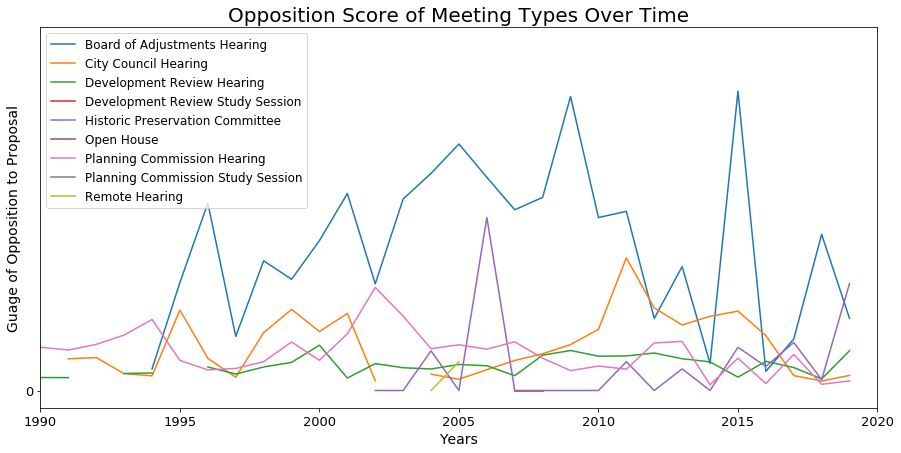

In [21]:
#plot opposition score over years
fig, ax = plt.subplots(figsize=(15,7))
Case_Data.groupby(['MeetingDate','MeetingType']).mean()['Opposition_Score'].unstack().plot(ax=ax)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel("Guage of Opposition to Proposal", fontsize=14)
plt.title("Opposition Score of Meeting Types Over Time",fontsize=20)
plt.xlabel("Years", fontsize=14)
plt.tick_params(labelsize=13)

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.set_xlim(1990, 2020)

#### The [Board of Adjustments](https://www.scottsdaleaz.gov/boards/board-of-adjustment) Hearing has consistently been the most contentious of all hearings, although this council contributes a relatively small number of hearings compared to the Development Review Hearing, City Council Hearings, and the Planning Commission.  This makes sense since the Board of Adjustment "has the power to hear and decide on appeals from administrative decisions and variances from the provisions of the zoning requirements. The Board of Adjustment makes the final decision on items that come before it; decisions are not passed on to the City Council for final approval".